In [17]:
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

In [100]:
class FourierConv2D(nn.Module):
    """
    Applies a 2D Fourier convolution over an input signal composed of several
    input planes. That is, 2D convolution is performed by performing a Fourier
    transform, multiplying a kernel and the input, then taking the inverse
    Fourier transform of the result.
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=True,
        bias=True,
    ):
        super(FourierConv2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        kernel_size = nn.modules.utils._pair(kernel_size)
        self.stride = nn.modules.utils._pair(stride)
        assert self.stride == (1, 1) or self.stride == (2, 2), "Stride must be (1, 1) or (2, 2)"
        self.padding = padding
        # kernel size depends on whether we pad or not
        if self.padding and self.stride == (1, 1):
            self.kernel_size = (kernel_size[0] * 2 - 1, kernel_size[1] * 2 - 1)
        else:
            self.kernel_size = kernel_size
        self.weight = nn.Parameter(
            torch.Tensor(out_channels, in_channels, *self.kernel_size, 2)
        )
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels, 1, 1))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = "{in_channels}, {out_channels}, kernel_size={kernel_size}"
        if self.bias is None:
            s += ", bias=False"
        return s.format(**self.__dict__)

    def forward(self, im):
        # determine input, output, and fourier domain sizes
        insize = im.size()
        outsize = (self.out_channels, im.size(-2), im.size(-1))
        if self.padding:
            fftsize = (insize[-2] + outsize[-2] - 1, insize[-1] + outsize[-1] - 1)
        else:
            fftsize = (im.size(-2), im.size(-1))

        # construct zero pad for real signal if needed
        if self.padding:
            pad_size = (
                0,
                fftsize[-1] - insize[-1],
                0,
                fftsize[-2] - insize[-2],
            )
        else:
            pad_size = (0, 1)
        # add channel for imaginary component and perform FFT
        fourier_im = torch.fft.fft2(F.pad(im, pad_size), dim=(-2, -1))
        
        # create complex convolution kernel
        kernel = self.weight[..., 0] + 1j * self.weight[..., 1]

        if self.stride != (1, 1):
            # skip inputs if stride > 1
            stride = self.stride
            fourier_im = fourier_im[:, :, :: stride[-2], :: stride[-1]]

        # calculate features in fourier space
        # (add dimension for batch broadcasting)
        fourier_feats = fourier_im.unsqueeze(1) * kernel

        # retrieve real component of signal
        real_feats = torch.fft.ifft2(fourier_feats).real

        # crop feature maps back to original size if we padded
        if self.padding and self.stride == (1, 1):
            cropsize = [fftsize[-2] - insize[-2], fftsize[1] - insize[-1]]
            cropsize_left = [int(c / 2) for c in cropsize]
            cropsize_right = [int((c + 1) / 2) for c in cropsize]
            real_feats = F.pad(
                real_feats,
                (
                    -cropsize_left[-1],
                    -cropsize_right[-1],
                    -cropsize_left[-2],
                    -cropsize_right[-2],
                ),
            )

        # sum over input channels to get correct number of output channels
        real_feats = real_feats.sum(2)

        # add bias term
        real_feats = real_feats + self.bias

        return real_feats

In [117]:
# create gaussian kernel
x, y = np.meshgrid(np.arange(512) - 256, np.arange(512) - 256)
kernel = np.exp(-((x**2 / (2 * 5**2)) + (y**2 / (2 * 5**2))))
# assign gaussian kernel to FourierConv2D
conv = FourierConv2D(1, 1, (512, 512))
torch_kernel = torch.fft.fft2(torch.from_numpy(kernel), s=(1023, 1023))
conv.weight = nn.Parameter(torch.stack([torch_kernel.real, torch_kernel.imag], dim=-1)[None, None, ...])
# convolve with FourierConv2D and scipy convolution
image = np.random.rand(512, 512)
result = conv(torch.from_numpy(image[None, None, ...]))
scipy_result = scipy.signal.fftconvolve(image, kernel, mode='same').real
# result should be identical to some tolerance
assert np.allclose(result.squeeze().detach().numpy(), scipy_result, rtol=1e-4)

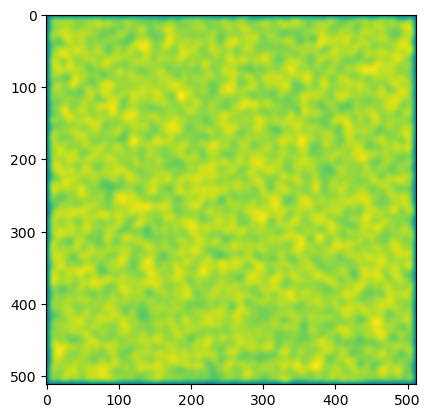

In [118]:
plt.imshow(result.squeeze().detach().numpy())

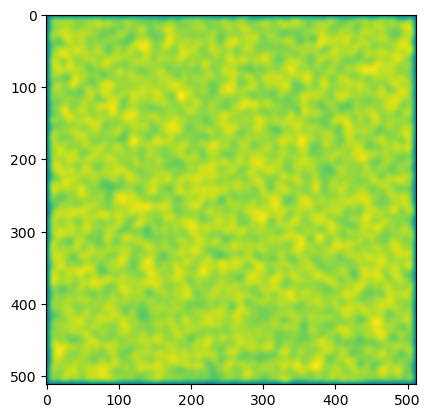

In [120]:
plt.imshow(scipy_result)